Temperature Forecast Project using ML
Problem Statement:
Data Set Information:

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.


Attribute Information:

For more information, read [Cho et al, 2020].
1. station - used weather station number: 1 to 25
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
19. lat - Latitude (Â°): 37.456 to 37.645
20. lon - Longitude (Â°): 126.826 to 127.135
21. DEM - Elevation (m): 12.4 to 212.3
22. Slope - Slope (Â°): 0.1 to 5.2
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9
24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9
25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8T

Please note that there are two target variables here: 

1) Next_Tmax: Next day maximum temperature

2) Next_Tmin: Next day  minimum temperature

In [30]:
!pip install lightgbm

In [33]:
!pip install category_encoders

In [34]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [4]:
data0 = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv")
data0[0:5].T

,0,1,2,3,4
station,1,2,3,4,5
Date,30-06-2013,30-06-2013,30-06-2013,30-06-2013,30-06-2013
Present_Tmax,28.7,31.9,31.6,32,31.4
Present_Tmin,21.4,21.6,23.3,23.4,21.9
LDAPS_RHmin,58.2557,52.2634,48.6905,58.2398,56.1741
LDAPS_RHmax,91.1164,90.6047,83.9736,96.4837,90.1551
LDAPS_Tmax_lapse,28.0741,29.8507,30.0913,29.7046,29.1139
LDAPS_Tmin_lapse,23.0069,24.035,24.5656,23.3262,23.4865
LDAPS_WS,6.81889,5.69189,6.13822,5.65005,5.735
LDAPS_LH,69.4518,51.9374,20.573,65.7271,107.966


In [5]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [6]:
data0=data0.fillna(0)

In [7]:
data0=data0.drop(['station','Date'],axis=1)

In [8]:
print(data0.columns.to_list())

['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']


In [9]:
target=['Next_Tmax','Next_Tmin']
datay=data0[target]
datax=data0.drop(target,axis=1)

In [10]:
print(datay[0:2].T)
print(datax[0:2].T)

              0     1
Next_Tmax  29.1  30.5
Next_Tmin  21.2  22.5
                            0            1
Present_Tmax        28.700000    31.900000
Present_Tmin        21.400000    21.600000
LDAPS_RHmin         58.255688    52.263397
LDAPS_RHmax         91.116364    90.604721
LDAPS_Tmax_lapse    28.074101    29.850689
LDAPS_Tmin_lapse    23.006936    24.035009
LDAPS_WS             6.818887     5.691890
LDAPS_LH            69.451805    51.937448
LDAPS_CC1            0.233947     0.225508
LDAPS_CC2            0.203896     0.251771
LDAPS_CC3            0.161697     0.159444
LDAPS_CC4            0.130928     0.127727
LDAPS_PPT1           0.000000     0.000000
LDAPS_PPT2           0.000000     0.000000
LDAPS_PPT3           0.000000     0.000000
LDAPS_PPT4           0.000000     0.000000
lat                 37.604600    37.604600
lon                126.991000   127.032000
DEM                212.335000    44.762400
Slope                2.785000     0.514100
Solar radiation   5992.895996  

In [11]:
n=len(data0)
print(n)

7752


In [12]:
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

In [13]:
trainX=datax.loc[N[0:(n//4)*3]]
trainY=datay.loc[N[0:(n//4)*3]]
testX=datax.loc[N[(n//4)*3:]]
testY=datay.loc[N[(n//4)*3:]]

In [14]:
print(trainX.shape)
print(testX.shape)


(5814, 21)
(1938, 21)


In [15]:
df_columns = list(datax.columns)
print(df_columns)

['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Solar radiation']


In [16]:
train_df=trainX
test_df=testX


In [17]:
train_df.columns=df_columns
test_df.columns=df_columns

In [18]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()


In [19]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [20]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [21]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 979.06it/s]

createcreate_numeric_feature  0.002[s]
createcreate_numeric_feature  0.001[s]


## Model

In [35]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models


In [36]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}


In [24]:
y = trainY
print(y.shape)
ydf=pd.DataFrame(y)
ydf

(5814, 2)


,Next_Tmax,Next_Tmin
6546,33.7,26.3
7137,35.1,27.3
3572,30.2,21.3
6285,32.1,23.2
293,23.8,22.8
...,...,...
2728,25.5,22.3
6783,27.6,24.8
1509,27.4,20.0
4617,31.8,21.2


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.75187
fit fold=0  0.228[s]
Fold 0 RMSLE: 1.7519

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	valid_0's rmse: 2.66078
fit fold=1  0.122[s]
Fold 1 RMSLE: 2.6608

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 1.86273
fit fold=2  0.251[s]
Fold 2 RMSLE: 1.8627

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	valid_0's rmse: 1.86358
fit fold=3  0.273[s]
Fold 3 RMSLE: 1.8636

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 2.13116
fit fold=4  0.114[s]
Fold 4 RMSLE: 2.1312

--------------------------------------------------
FINISHED | Whole RMSLE: 2.0801
Training until validation scores don't improve for 100 rounds
Early s

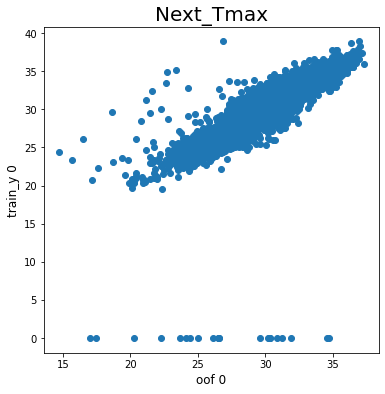

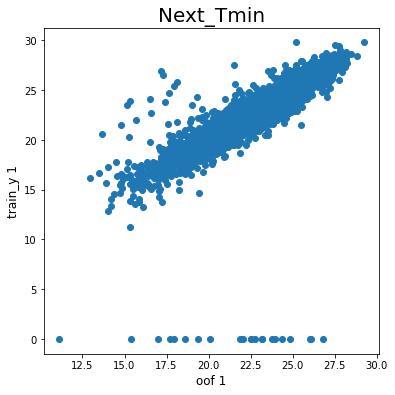

In [37]:
from sklearn.model_selection import KFold

for i in range(2):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('oof '+str(i),fontsize=12)
    ax.set_ylabel('train_y '+str(i),fontsize=12)
    ax.scatter(oof,y)

In [26]:
print(target)

['Next_Tmax', 'Next_Tmin']


# Visualize Importance and Predict

In [27]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.75187
fit fold=0  0.185[s]
Fold 0 RMSLE: 1.7519

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	valid_0's rmse: 2.66078
fit fold=1  0.133[s]
Fold 1 RMSLE: 2.6608

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 1.86273
fit fold=2  0.206[s]
Fold 2 RMSLE: 1.8627

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	valid_0's rmse: 1.86358
fit fold=3  0.277[s]
Fold 3 RMSLE: 1.8636

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 2.13116
fit fold=4  0.117[s]
Fold 4 RMSLE: 2.1312

--------------------------------------------------
FINISHED | Whole RMSLE: 2.0801
Training until validation scores don't improve for 100 rounds
Early s

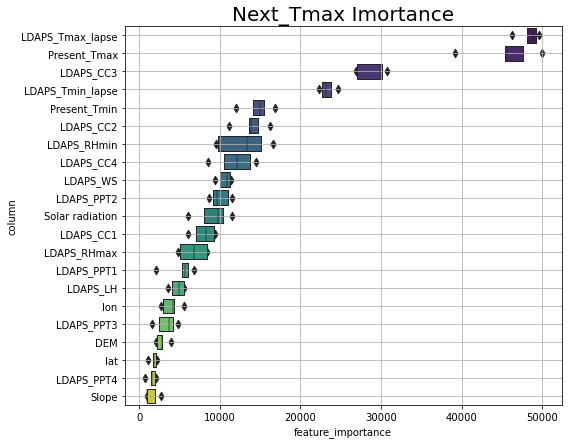

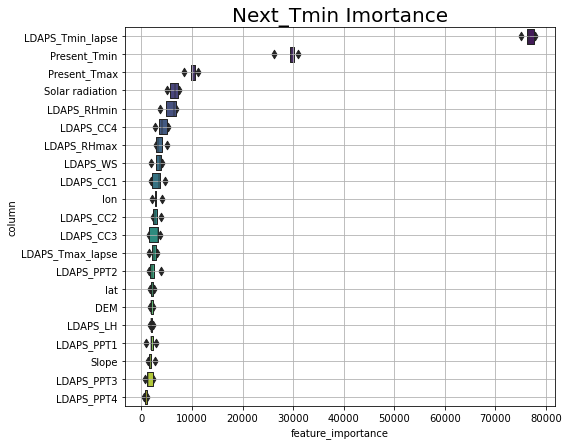

In [38]:
pred1=[]
for i in range(2):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)
    pred0 = np.array([model.predict(test_feat_df.values) for model in models])
    pred1+=[np.mean(pred0, axis=0)]

In [39]:
pred1=np.array(pred1)
testY=np.array(testY)


In [40]:
print(pred1.T.shape)
print(testY.shape)

(1938, 2)
(1938, 2)


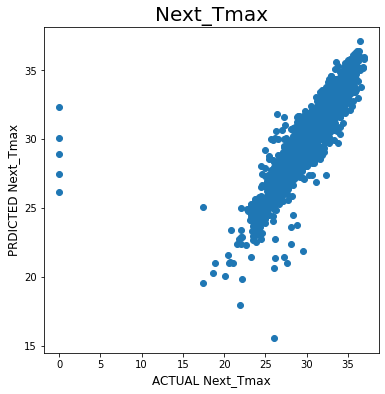

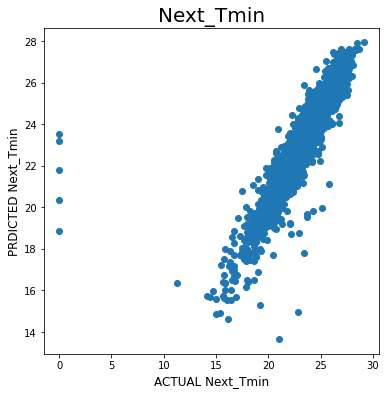

In [41]:
for i in range(2):
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('ACTUAL '+target[i],fontsize=12)
    ax.set_ylabel('PRDICTED '+target[i],fontsize=12)
    ax.scatter(testY[:,i],pred1.T[:,i])
